In [1]:
using Sunny, LinearAlgebra, Random, Formatting, Statistics
using FFTW  # If necessary, type `] add FFTW` in the REPL to install
import Plots

# Determining Simulation Parameters

We have tried to make the process of setting up a model and calculating a structure factor as seamless as possible. However, the best values for certain simulation parameters will necessarily depend on the model under investigation. To get the best results (in the least amount of time), setting these parameters correctly is very important. In this tutorial, we give some guidelines on how to set these parameters based on the properties of an arbitrary model.

In particular, we will discuss the following:
1. **Configuring integrators**: How to set the time step for integrators.
2. **Determining thermalization and decorrelation times**: How to use the Langevin dynamics effectively to perform Monte Carlo.
3. **Setting up dynamical structure factor calculations**: How to set up a dynamical structure factor calculation using the information determined in steps 1 and 2.

We will go through the steps in some detail. We stress, however, that more most use cases, some simple guidelines will suffice. These will be summarized at in the final section. The new user should feel free to skip to this summary. The content of this tutorial will be of primary interest to those who wish to optimize their calculations.

## 0. Example model

For the purposes of making a concrete demonstration, we will define a function that creates a `SpinSystem` on a diamond lattice with only nearest-neighbor AFM Heisenberg interactions. Although we will just use conventional Landau-Lifshitz dynamics, we will treat the spins as having effective spin$=\frac{3}{2}$ and rescale their magnitudes accordingly. The choice of model was essentially arbitrary, and the process outlined below can be repeated for any model.

In [2]:
function diamond_lattice_model(; J = 1.0, spin_rescaling = 3/2, dims = (8, 8, 8), rng=MersenneTwister())
    crystal = Sunny.diamond_crystal()
    interactions = [
        heisenberg(J, Bond(1, 3, [0,0,0])),
    ]

    site_infos = [SiteInfo(1; spin_rescaling)]
    
    return SpinSystem(crystal, interactions, dims, site_infos; rng)
end;

## 1. Setting up an integrator

Sunny provides two classes of integrator: an RK-type integrator for simulating dynamics in the presence of a thermal bath, and a symplectic integrator for calculating conservative dynamics. The first can be created with `LangevinHeunP`, and the second with `ImplicitMidpoint`. For the purposes of constructing a structure factor, the Langevin integrator is used to thermalize the spin system and to sample spin configurations at thermal equilibrium. The symplectic integrator is used for calculating long-time dynamics without noise or damping. More specifically, the initial conditions for the sympletic integrator are generated by the Langevin integrator.

While the Langevin integrator can be used to perform equilibrium Monte Carlo simulations as just described, it has a number of other important applications. Because the dynamics includes a damping term, it can be used to perform optimization tasks, e.g., finding ground states. And, perhaps more interestingly, it can also be used to simulate out-of-equilibrium dynamics.

In the following, we discuss how to set up each of these integrators.

### Langevin Integration

   A Langevin integrator can be created as follows: `integrator = LangevinHeunP(sys, kT, α)`. The first argument is a spin system, the second is the temperature of the thermal bath (given in meV), and the final argument specifies the coupling to the thermal bath. Note that `α` is an empirical term that can be adjusted either to match the known behavior of your system or to tune the sampling process. In particular, this parameter determines a time scale, `α`$^{-1}$, relevant to the decorrelation time of the system.

To advance the state of your spin system using this integrator, one calls: `evolve!(integrator, Δt)`. In this section we will discuss how to determine `Δt`. Assuming that you wish to integrate for some fixed duration of time (typically in meV$^{-1}$), it will take fewer steps the larger `Δt` is. As the calculation for a single time step is deterministic for this integrator, this means that the simulation time is strictly inversely proportional to `Δt`. However, if `Δt` is chosen too large, the integrator will become unstable and the results will be meaningless. It is also possible to choose `Δt` just slightly too large, in which case it may appear the integrator is working, but you will not be sampling from the correct equilibrium distribution for your chosen `kT`. If it appears you are getting reasonable results, and good check is to decrease `Δt` a bit and make sure your statistics do not change. If so, you can probably be confident in your original choice of time step.

A general rule of thumb for selecting the time step is this: `0.02/J`, where J is the largest parameter in your Hamiltonian. However, this rule gets modified slightly if the magnitude of your spin is not 1. This occurs if you either apply spin rescaling or use SU(_N_) dynamics. A more complete guideline can be written as follows,

`Δt = 0.02 / ((spin_rescaling*|S|)^2 * J)`,

where `spin_rescaling` is a parameter of `SiteInfo` (which defaults to 1), `|S|` is the total magnitude of the spin before rescaling, and `J` is the largest *exchange* parameter is your Hamiltonian. 

Note that `|S|=1` for the default, Landau-Lifshitz dynamics, which is what you get if you do not specify an `N` when declaring site information, e.g., `SiteInfo(1; spin_rescaling=3/2)`. When you are performing generalized, SU(_N_) dynamics, then `|S|=(N-1)/2`. For example, if were using SU(4) dynamics, we would use something like `SiteInfo(1; N=4)`, and this would result in a spin magnitude of `|S|=3/2`. 

One final caveat. Note the square of the spin magnitude in the denominator of expression. This is a consequence of the spin magnitude appearing quadratically in an exchange interaction. For models with a large single-ion anisotropy, its possible that `spin_rescaling*|S|*D`, where `D` is the anisotropy parameter, is larger than `(spin_rescaling*|S|)^2 * J`. In this case, set the time step as follows:

`Δt = 0.02 / (spin_rescaling*|S| * D)`.

Note that the spin magnitude only appears linearly in this expression since it is a single site property.

#### Summary
For a Langevin integrator, set your `Δt` to the _smaller_ of the following two values:

`Δt = 0.02 / ((spin_rescaling*|S|)^2 * J)`

`Δt = 0.02 / (spin_rescaling*|S| * D)`

where `J` is the largest exchange parameter, and `D` is the largest anisotropy parameter.

#### Example

In the code snippet below, we show how to instantiate a Langevin integrator for our model system. We advance the system one step in time just to make sure everything is working.

In [3]:
# Set up model parameters and make spin system
J = Sunny.meV_per_K * 7.5413  # Units of meV
spin_rescaling = 3/2  # Using standard LL dynamics, rescaling dipoles to magnitude 3/2
sys = diamond_lattice_model(; J, spin_rescaling)  # Get a spin system using these parameters
rand!(sys)  # Random initial conditions

# Set up integrator
α  = 0.1  # Empirical noise/damping parameter
kT = 1.0  # Temperature (meV)
langevin_int = LangevinHeunP(sys, kT, α) # Instantiate an integrator

# Set time step and evolve one step
Δt_lang = 0.02 / (spin_rescaling^2 * J)  # Follow our guidelines. Since LL dynamics, |S|=1
evolve!(langevin_int, Δt_lang)  # Advance one step forward in time

### Implicit Midpoint Integration

If you are only using Sunny to create models and calculate structure factors, you will likely never need to create an implicit midpoint integrator yourself. Nonethless, it is the integrator used "behind the scenes" when calculating a dynamical structure, so having some idea how these integrators behave is important. In particular, the time step that is specified when calling `dynamic_structure_factor` is in fact passed to an internal `ImplicitMidpoint` integrator, so you must have some idea how to set this time step.

Sunny's implicit midpoint integrators are sympletic, meaning that they take advantage of the Hamiltonian structure of the equations of motion to advance the spin system in such a way that energy is conserved. More precisely, the error in the energy will always be bounded. How wide the bounds are will depend on how large the step size is. Additionally, if the the step size is far too large, the integrator will fail to converge entirely. Sunny will throw an error with explanation in this case.

Initializing an implicit midpiont integrator is straightforward. There is no thermal bath, so there are no parameters to set.

In [4]:
midpoint_int = ImplicitMidpoint(sys);  # Reusing the spin system made in previous cell 

A general guideline for setting the time step with an implicit integrator is this: use a step size 5 to 10 times larger than what you would use for a Langevin integrator:

 `Δt_mid = 5*Δt_langevin`.
 
Let us examine what happens to the energy when we use this value, as well as values half and twice as large. To do this, we will write a short function to evolve a spin system for a fixed duration while recording the energy. 

In [6]:
function energy_trajectory(integrator, Δt, dur=100.0)
    numsteps = round(Int, dur/Δt)
    numspins = *(size(integrator.sys)...)
    Es = zeros(numsteps)
    for i in 1:numsteps
        evolve!(integrator, Δt)
        Es[i] = energy(integrator.sys) / numspins
    end
    return Es
end;

We now use this function to evolve a spin system. We will use three different step sizes, using identical initial conditions for each trial.

In [7]:
# Set step sizes. Recall Δt was our choice for the Langevin integrator
Δt_ref = Δt_lang*5  # Start out with five times the value we used for the Langevin integrator
Δt_small = Δt_ref/2 # Half the size
Δt_large = Δt_ref*2 # Twice the size

# Set up the spin system and integrator
seed = 122
rng = MersenneTwister(seed)
sys = diamond_lattice_model(; J, spin_rescaling, rng)
rand!(sys)
midpoint_int = ImplicitMidpoint(sys);  # Reusing the spin system made in previous cell 

# Calculate energy trajectories for different step sizes
Random.seed!(rng, 111)
rand!(sys)
Es_small = energy_trajectory(midpoint_int, Δt_small)

Random.seed!(rng, 111)
rand!(sys)
Es_ref = energy_trajectory(midpoint_int, Δt_ref)

Random.seed!(rng, 111)
rand!(sys)
Es_large = energy_trajectory(midpoint_int, Δt_large);

Let's plot the energy trajectories we just collected.

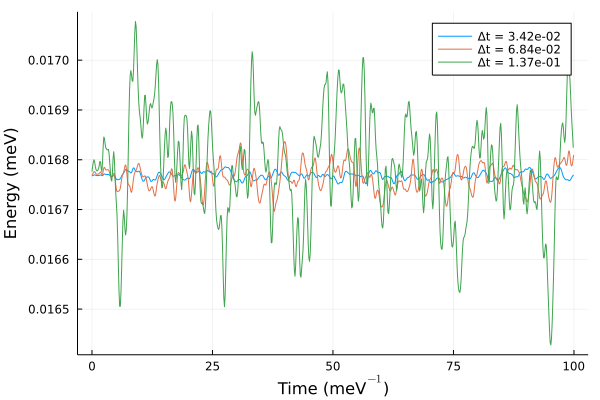

In [8]:
# Plot results
ts_small = Δt_small .* collect(0:length(Es_small)-1)
ts_ref = Δt_ref .* collect(0:length(Es_ref)-1)
ts_large = Δt_large .* collect(0:length(Es_large)-1)

p = Plots.plot(; fmt=:png, xlabel=raw"Time (meV$^{-1}$)", ylabel="Energy (meV)")

Plots.plot!(ts_small, Es_small; label="Δt = $(format("{:1.2e}", Δt_small))")
Plots.plot!(ts_ref, Es_ref; label="Δt = $(format("{:1.2e}", Δt_ref))")
Plots.plot!(ts_large, Es_large; label="Δt = $(format("{:1.2e}", Δt_large))")

The energy should be conserved, so any deviation from the initial energy is an error. That the errors are bounded is clearly visible, and they are guaranteed to remain this way indefnitely. Note that every doubling of the step size results in the error increasing by a factor of 4. While seeing some error in the energy may be alarming, note that in all cases the overall error is fairly small, on the order of $10^{-3}$ for the largest step size. However, if any low-energy artifacts are visible in your results, it's possible this is a sign that your `ImplicitMidpoint` integrator needs to be evolved with a smaller step size. Recall that the step size you give to `dynamic_structure_factor` is a step size used by an `ImplicitMidpoint` integrator.

It should also be mentioned that, for the purposes of calculating a structure factor, the highest energy that you are able to resolve will be limited by the step size. Specifically: $\omega_{\textrm{max}} = \frac{\pi}{\Delta t}$. In general you will find that all physically relevent energies will be captured for any step size small enough to ensure that the integrator converges. In other words, you generally won't have to worry about an interaction between your integration step size and the maximum energy you wish to resolve. If you do have a problem in this regard, Sunny will point it out to you.

Let's also examine what happens when a step size that is far too large is selected, for example 100 times larger than the reference we defined above.

In [9]:
Δt_bad = Δt_lang * 25 # Select a very large step size.

Random.seed!(rng, 111) # This line and the next ensure identical initial conditions to what was used above
rand!(sys)
Es_bad = energy_trajectory(midpoint_int, Δt_bad)

LoadError: Spherical midpoint method failed to converge to tolerance 1.0e-12 after 100 iterations.

The integrator failed to converge entirely, and Sunny explains to you what happened.

We know from experience (and will show below) that setting the step size for the midpoint integrator to 10 times the size used for the Langevin integrator is perfectly adequate for this model.

## 2. Determing thermalization and decorrelation times

A central step in the calculation of a dynamical structure factor is the sampling of spin configurations at thermal equilibrium. There are two major components to this process. First, the system must be thermalized at the desired temperature. Second, since many samplers will produce successive samples that are correlated, it is necessary to know how many samples to skip between collecting samples. We demonstrate here how to achieve these goals with a `LangevinSampler`.

A `LangevinSampler` is essentially a `LangevinHeunP` integrator wrapped up with some additional information, in particular the number of time steps that the sampler should advance before offering up a new (hopefully uncorrelated) sample. So we will begin our investigation by looking at the behavior of a Langevin integrator and use the results to build a `LangevinSampler`.

In the following, we will examine how magnetization evolves over time. In general, you will want to perform a similar analysis using a time series of whatever order parameter is relevant to your system. We begin by writing a simple function for extracting the magnetization.

In [10]:
function magnetization(sys::SpinSystem)
    numspins = *(size(sys)...)
    return 2*norm(sum(sys._dipoles)) / numspins # 2 is quick and dirty incorporation of isotropic g-factor
end

println("<M> initial: ", magnetization(sys))

<M> initial: 0.06464378313071338


Next we will write a function to evolve the system while recording the magnetization.

In [11]:
function mag_trajectory(integrator, Δt, dur=20.0)
    numsteps = round(Int, dur/Δt)
    numspins = *(size(integrator.sys)...)
    mags = zeros(numsteps)
    for i in 1:numsteps
        mags[i] = magnetization(integrator.sys) / numspins
        evolve!(integrator, Δt)
    end
    return mags
end;

Let's now generate a dynamical trajectory, starting at a random initial condition, and examine how the magnetization behaves over time.

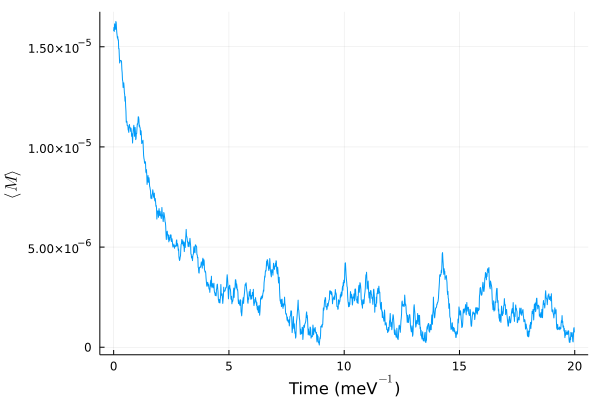

In [12]:
Random.seed!(rng, 111) # For repeatable initial conditions
rand!(sys) # Random initial conditions
kT = 2.0 * Sunny.meV_per_K  # T = 2 K
α = 0.1 # Safe choice for damping parameter
langevin_int = LangevinHeunP(sys, kT, α) # Make the integrator
Ms = mag_trajectory(langevin_int, Δt_lang, 20.0) # Generate a dynamical trajectory and record magnetization

ts = collect(0:length(Ms)-1) .* Δt_lang  # Generate x-axis values

# Plot the results
Plots.plot(ts, Ms;
    fmt=:png, xlabel=raw"Time (meV$^{-1}$)", ylabel=raw"$\langle M \rangle$", label=nothing)

We can estimate the thermalization time by examining how long it takes for the system to to settle into regime that exhibits bounded deviations around a mean value. In this case, we can see this occurs between 10 and 15 meV$^{-1}$. Of course, this is just one sample. Let's collect a number of them and average.

In [13]:
samples = []
Random.seed!(111) # For repeatable results
for _ in 1:100
    rand!(sys)  # Random initial condition
    Ms = mag_trajectory(langevin_int, Δt_lang, 20.0)
    push!(samples, Ms)
end

Ms_avg = mean(samples);

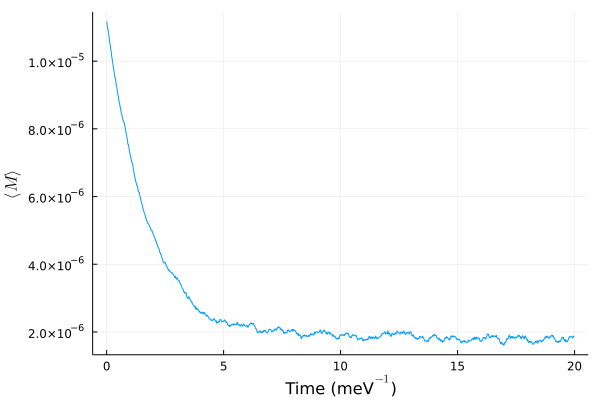

In [14]:
ts = collect(0:length(Ms_avg)-1) .* Δt_lang  # Generate x-axis values
Plots.plot(ts, Ms_avg; fmt=:png, xlabel = raw"Time (meV$^{-1}$)", ylabel = raw"$\langle M \rangle$", label=false)

If you wish to be truly precise, you can fit an exponential to the initial decay and use the resulting fit to determine the thermalization time. We will just eyeball what appears to be a reasonable value and see how many steps this amounts to with our chosen step size.

In [16]:
round(Int, 10.0/Δt_lang)

731

So, to be safe, we will say that the system requires 800 updates at this temperature and with this step size to thermalize from a random initial condition.

### Decorrelation time

Now that we know how long to run the Langevin integrator to thermalize the system, let's determine how long the `LangevinSampler` needs to be run between collecting samples.

To do this, we will need to estimate how long it takes for the system to decorrelate. A standard way of estimating the decorrelation time is to calculate the autocorrelation of the relevant time series (here magnetization), and examine the width of the peak centered at zero delay.

There is an easy and fast way to calculate the autocorrelation using a fast Fourier transform. We will use Julia's `FFTW` package to write a short function that does just this.

In [19]:
using FFTW

# A simple function for calculating the autocorrelation
function autocorr(sig; step_bound = 100)
    sig_ft = fft(sig) # Fourier transform
    spec = sig_ft .* conj(sig_ft) # Fourier transform squared
    spec[1] *= 0 # Remove mean
    AC = fftshift(ifft(spec)) .|> real # Autocorrelation as inverse Fourier transform of power spectrum (Wiener-Khinchin)
    
    n_max = div(length(AC), 2) # Maximum number of steps
    ns = collect(0:length(AC)-1) .- n_max 
    i_min = findfirst(>(-step_bound-1), ns)
    i_max = findfirst(>(step_bound+1), ns)
    
    ns, AC = ns[i_min:i_max], AC[i_min:i_max]
    
    return (;ns, AC)
end;

We'll now initialize our system in a random initial condition, thermalize it (which we now know takes about 10 meV$^{-1}$), and calculate the autocorrelation of a single trajectory.

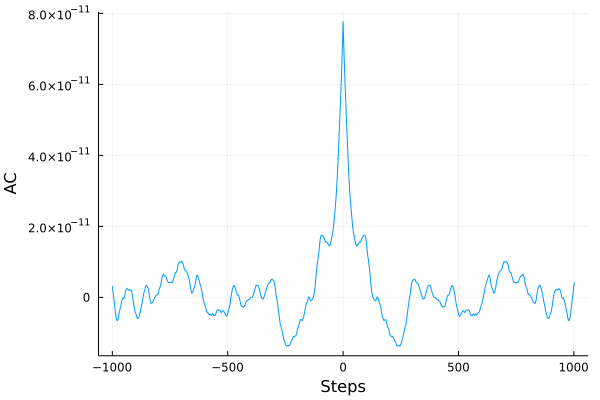

In [29]:
Random.seed!(111)
rand!(sys)
kT = 2.0 * Sunny.meV_per_K  # T = 2 K
α = 0.1 # Safe choice for damping parameter
langevin_int = LangevinHeunP(sys, kT, α) # Make the integrator

therm_dur = 12.5
therm_steps = round(Int, therm_dur/Δt_lang)
for _ in 1:therm_steps
    evolve!(langevin_int, Δt_lang)
end

Ms = mag_trajectory(langevin_int, Δt_lang, 50.0)
(; AC, ns) = autocorr(Ms; step_bound = 1000)


Plots.plot(ns, AC; xlabel="Steps", ylabel="AC", label=nothing, fmt=:png)

From this single sample, it appears the peak width (and hence docorrelation time) is about 200 steps. Let's repeat this process for a number of samples to get a cleaner answer.

In [30]:
samples = []
numsamples = 20

ns = nothing
ACs = []
Random.seed!(rng, 111)
for _ in 1:numsamples
    Ms = mag_trajectory(langevin_int, Δt_lang, 50.0)
    (; AC, ns) = autocorr(Ms; step_bound = 1000)
    push!(ACs, AC)
end

AC_avg = mean(ACs);

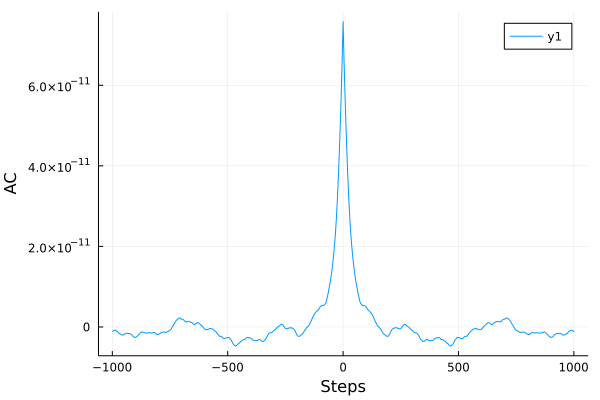

In [31]:
Plots.plot(ns, AC_avg; fmt=:png, xlabel="Steps", ylabel="AC")

By "eyeball," it appears that 200 steps is safe. If you wish to be precise, you can fit an exponential $e^{t/\tau}$ to the initial decay, and take the results $\tau$ as the decorrelation time.

## 3. Setting up a dynamic structure factor calculation

We have now determined most of the essential parameters to calculate a dynamic structure factor. We summarize them below.

In [23]:
# Langevin parameters
Δt_lang = 0.0137 # 0.02/((spin_rescaling*|S|)^2 * J)
num_therm = 800  # Number of steps to thermalize system at kT = 2.0 * (meV/K) 
num_decorr = 200 # Number of steps for samples to decorrelate

# Midpoint parameters
Δt_mid = 0.137;   # 10 x Δt_lang

This information is enough to set up a `LangevinSampler`. This sampler will be used to generate initial conditions for our calculation of dynamical trajectories.

In [24]:
# Set up a fresh system
J = Sunny.meV_per_K * 7.5413  
spin_rescaling = 3/2  
sys = diamond_lattice_model(; J, spin_rescaling, dims=(12, 12, 12))

# Set up the sampler
kT = 2.0 * Sunny.meV_per_K
α = 0.1
sampler = LangevinSampler(sys, kT, α, Δt_lang, num_decorr);

We recall now the arguments to the `dynamic_structure_factor`:

```
function dynamic_structure_factor(sys, sampler;
    nsamples=10, dt=0.01, thermalize=10,
    omega_max=nothing, num_omegas=100, bz_size=(1,1,1),
    reduce_basis=true, dipole_factor=false, verbose=false)
```

Note that all arguments after the colon are optional, but we will go through them in detail.

* `nsamples` is simply the number of initial conditions, and hence number of trajectories, that are used in the calculation. We will accept the default value of 10. For low temperatures, it is not generally necessary to collect many samples.
* `dt` is the time step used to evolve the internal `ImplicitMidpoint` integrator when calculating calculate the dynamical trajectories. We have determined to use a value of 0.137.
* `thermalize` determines the number of times to run the sampler before beginning the process of collecting samples. We have determined that, starting from a random initial condition, our system thermalizes in about 800 steps. Our sampler runs 200 steps each time it is called. So we will set `thermalize=4`.
* `omega_max` is the maximum energy that will be resolved by the calculation. The upper limit is determined by `dt`. Specifically, $\omega_{\textrm{max}} = \frac{\pi}{dt}\approx 22.9 \textrm{meV}^{-1}$ in our case. As we are only interested in energies below 8 meV or so for this model, we will set this to 8.
* `num_omegas` determines the discretization of the $\omega$ axis. Specifically, it determines how many energy "bins" there will be between 0 and `omega_max`. The larger this value is, the longer the simulation will take. We will chose `num_omegas=100`. 
* `bz_size` sets the number of Brioullin zones to generate. Sunny can only calculate the first Brioullin zone in principle, but this can be periodically extended. This is useful when applying form factor corrections, for example. We will accept the default value here.
* `reduce_basis` determines whether to phase-average over different sites in the crystallagraphic unit cell. The way the diamond cyrstal has been set up for this calculation, there are 8 sites per cell, and we will average over them, i.e. set `reduce_basis=true`.
* `dipole_factor` determines whether to apply the magnetic dipole factor corrections to the resulting structure factor. This is useful for comparing with neutron scattering data, and we will set this value to true. 
* `verbose` simply determines whether to report progress during the calculation. We will again set this to true.

We now have everything we need to perform the actual calculation.

In [25]:
Random.seed!(rng, 111)
rand!(sys) # Start from a random initial condition

sf = dynamic_structure_factor(sys, sampler; 
    dt=Δt_mid, thermalize=4, omega_max=6.0, num_omegas=100,
    reduce_basis=true, dipole_factor=true, verbose=true,
)

Beginning thermalization...
Done thermalizing. Beginning measurements...


Sample: 100%|███████████████████████████████████████████| Time: 0:00:31


12x12x12x100 StructureFactor

We can extract a path from this structure factor using the Sunny function `sf_slice`. We simply need to specify a series of points in momentum space. 

In [26]:
points = [(0, 0, 0), (π, 0, 0), (π, π, 0), (0, 0, 0)]
(; slice, idcs) = sf_slice(sf, points; return_idcs=true);

All that remains is to plot. We have an analytical expression for the dispersion from linear spin wave theory, and we will plot this on top of Sunny's results.

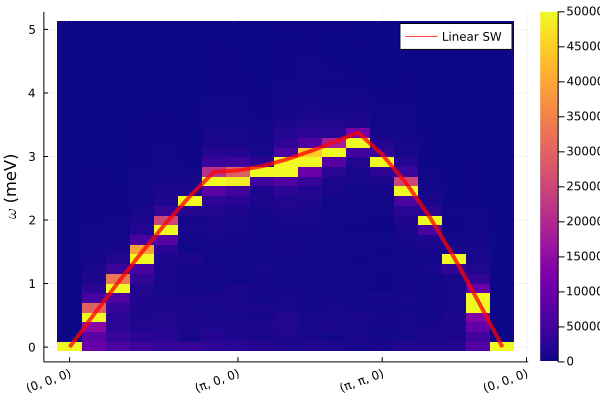

In [27]:
chopω = 5.0
ωs = omega_labels(sf)
chopω = isnothing(chopω) ? ωs[end] : chopω
i_cutoff = findfirst(s -> s > chopω, ωs)

p = Plots.heatmap(1:size(slice, 1), ωs[0:i_cutoff], slice[:,0:i_cutoff]';
    color=:plasma, clim=(0.0, 5e7), xrotation=20, ylabel = "E (meV)",
    fmt=:png
)

point_labels = map(x -> "($(x[1]), $(x[2]), 0)", points)
Plots.xticks!(idcs, point_labels)



# Plot the analytic linear spin-wave prediction ω(q) on top
function linear_sw_diamond_heisenberg(q, J, S)
    exp1 = exp(im * π * (q[1] + q[2]))
    exp2 = exp(im * π * (q[2] + q[3]))
    exp3 = exp(im * π * (q[1] + q[3]))
    return 4 * J * S * √(1 - abs(1 + exp1 + exp2 + exp3)^2 / 16)
end

qz = 0.0
spin = 3/2
Lx, Ly, Lz = round.(Int, size(sf.sfactor)[1:3] ./ sf.bz_size)
πx, πy, _ = map(l->div(l, 2, RoundUp), (Lx, Ly, Lz)) # Indices of (π, π, π)
qs = zeros(Sunny.Vec3, πx+πy+min(πx,πy)+1)
for i in 1:πx+1
    # qs[i] = Sunny.Vec3((i-1)/(2πx), 0, qz/(2πz))
    qs[i] = Sunny.Vec3((i-1)/(2πx), 0, qz/(2π))
end
for i in 1:πy
    qs[πx+1+i] = Sunny.Vec3(0.5, i/(2πy), qz/(2π))
end
for i in 1:min(πx,πy)
    qs[πx+πy+1+i] = Sunny.Vec3(0.5-i/(2πx), 0.5-i/(2πy), qz/(2π))
end
ωs_sw = linear_sw_diamond_heisenberg.(qs, J, spin)
Plots.plot!(1:length(ωs_sw), ωs_sw, lw=4, la=0.75, color=:red, label="Linear SW")

Plots.ylabel!(raw"$\omega$ (meV)")
Plots.plot!()

## Summary

While we have gone through this process in great detail, we should emphasize that in many cases Sunny can be used quickly and with confidence if the following guidelines are used.

* When setting up a `LangevinIntegrator` of `LangevinSampler`, choose a step size that is the smaller of the following two values:
    1. `Δt = 0.02 / ((spin_rescaling*|S|)^2 * J)`
    2. `Δt = 0.02 / (spin_rescaling*|S| * D)`

where `|S|=1` for standard Landau-Lifshitz dynamics and `|S|=(N-1)/2` for SU(_N_) dynamics; J is the largest exchange parameter, and D is the largest anisotropy parameter.
* Choose a step size for the `ImplicitMidpoint` integrator that is 5-10 times larger than this. This includes the value assigned to `dt` when calling `dynamic_structure_factor`.
* When setting up a `LangevinSampler`, choose `nsteps` large enough to ensure that successive samples are decorrelated.
* If your system is thermalized completely before starting a `dynamic_structure_factor` calculation, you can set the keyword `thermalize=0`. Otherwise tell Sunny to run the sampler `thermalize` times to prepare the system before collecting samples.
* If you know you are only interested in energies below some cutoff, pass a value to `omega_max` when calling `dynamic_structure_factor`. This is given in units of meV.
* Pass an integer to `num_omegas` to determine the number of energies to resolve between 0 and `omega_max`.